In [1]:
import numpy as np
import gurobipy as gp
import pandas as pd
from math import floor 
from math import sqrt
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [2]:
#reading in the training data
df_train = pd.read_csv('training_data.csv')
df_train.head()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,8.536145,-1.535413,0.718888,-2.099149,-0.442842,-0.598978,-1.642574,0.207755,0.760642,0.575874,...,0.361866,1.793098,-0.631287,-0.061751,0.511049,0.488754,-0.612772,-0.471045,-1.139781,-0.260773
1,4.808344,-1.734609,0.551981,-2.147673,-1.552944,1.514910,-1.143972,0.737594,1.321243,-0.261684,...,-0.677985,-0.165679,0.065405,0.137162,1.258197,-0.120834,-1.564834,-0.242565,-0.001827,1.187453
2,-1.530427,0.097257,0.107634,-0.194222,0.335454,-0.408199,0.133265,0.706179,0.394971,-0.437116,...,1.108801,0.333791,0.282055,-1.086294,-0.115354,0.257857,-0.088838,-0.751231,1.450609,0.290593
3,-0.428243,-0.067702,0.557836,0.700848,-1.121376,1.722274,0.613525,0.700909,-0.417976,1.069749,...,0.692511,-0.350990,0.624558,0.434520,-0.367409,-1.144681,-0.136524,-0.557214,0.416303,0.484495
4,0.566694,0.488729,0.211483,0.568389,0.646837,0.163868,-0.002152,0.125137,0.493571,1.705451,...,-0.000605,1.075280,0.182281,-1.138458,0.106092,0.544640,-0.383487,-0.425773,2.667647,-0.050748


In [3]:
#reading in the test data
df_test = pd.read_csv('test_data.csv')
df_test.head()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,7.107949,-2.047008,0.260132,-0.785152,0.384576,-0.137613,-0.364566,-1.941253,-0.108180,-0.339223,...,-0.522194,1.861897,0.124511,1.144071,0.128179,-0.467972,-1.085601,0.659670,0.514719,0.806656
1,5.796272,-1.354328,-1.289884,1.321533,-0.091165,-1.021874,0.686778,0.089737,-0.398371,-0.261740,...,-0.502578,0.584476,0.680703,0.046788,0.569681,-1.099062,-0.069656,0.709273,-0.848665,0.996168
2,1.598651,0.502205,1.062887,1.460733,-1.506403,0.721664,0.528921,-0.699541,-0.270331,-2.544812,...,-0.125195,-1.292924,0.411785,-0.164210,-2.407403,-1.132500,0.452923,-0.945541,0.126523,-0.972075
3,2.532953,0.222381,-0.960747,-0.113762,1.935927,0.969387,-1.641403,0.026647,0.747138,-1.571784,...,-0.546915,-0.192517,0.603420,-0.277331,-1.451419,0.220775,0.474954,-0.160109,0.188047,-1.711229
4,0.590685,1.209949,1.586874,-0.694784,-0.226370,-0.152108,0.772356,-0.573741,-0.992492,-0.646661,...,-0.982236,-1.407777,0.094211,0.159960,-0.901612,-1.653122,0.393518,0.702539,0.552663,-0.773646


In [4]:
#converting training data to numpy array and adding 1s in the first column for bias term(beta 0) and columns with 0s
# after the data so that when we construct our sigma matrix for the MIQP problem the extra decision variables will 
# be taken into account automatically

train_x = df_train.iloc[:,1:].to_numpy()
m_total = train_x.shape[1]
ndata = train_x.shape[0]

b = np.ones((ndata,1))
train_x = np.hstack((b,train_x))
c = np.zeros((ndata,m_total))
train_x = np.hstack((train_x,c))
train_y = df_train.iloc[:,0].to_numpy() 

#same operations as training data are done to the test data

test_x = df_test.iloc[:,1:].to_numpy()
ndata_test = test_x.shape[0]
b = np.ones((ndata_test,1))
test_x = np.hstack((b,test_x))
c = np.zeros((ndata_test,m_total))
test_x = np.hstack((test_x,c))
test_y = df_test.iloc[:,0].to_numpy() 

In [5]:
# creating a matrix with 10 rows and (training data size/10) number of columns of index numbers. Each selected 
# row is a set will have the indices of the rows in the training data whih will be considered as validation dataset
# the other 9 rows are of indices are the training data indices which will be used to get the coefficients in each run
# of cross-validation
shuf = np.random.choice(range(ndata),size=ndata,replace=False)
shuf = shuf.reshape(10,int(ndata/10))
shuf

array([[243,  94, 196, 144,  53, 140,  30, 131, 230,  91,   4,  65,  89,
         70, 128, 225,  76,  93,  37, 188, 119, 214,  35, 241, 211],
       [180, 210, 101, 207, 110, 223,  61, 103,  25, 198,  47, 137,  36,
        152,  69, 155, 232, 115,  54,  67,  83,  56, 139, 130, 205],
       [204, 234, 174, 236,  55, 183, 218,  44, 112, 159,  16, 109, 122,
          9,  33, 249, 177,   8, 156, 194,  19, 173,  66,   5,  62],
       [ 50, 182,   2,  26,  48,  79, 242, 165, 216,  24, 142, 124, 157,
         21, 224,  59,   6, 203, 201, 181,  20, 129,  82,  32,  22],
       [229,   7, 237,  38, 215,  99, 162, 240, 138, 239, 135, 186, 149,
         13, 107, 206,  84, 136, 226, 117, 199,  52, 245, 233,  57],
       [172,  14, 202, 160,  41, 126, 106,  75, 246, 134,  98,  71, 192,
        151, 221, 125, 247, 123,  46, 179, 164,  72,  64, 167,  28],
       [169,  78, 166,  15, 195,  97, 212, 185,   3, 219, 132,  17,  73,
         42, 213, 238,  90, 147,  86, 102,  27,  51, 168,  63, 208],
      

In [6]:
A = np.zeros((2*m_total+1,1+2*m_total))
A[0,m_total+1:] = 1 # limiting number of non-zero beta coefficients
M = 1000 # Big M constraint
for i in range(1,m_total+1):
    A[i,i] = 1
    A[i,m_total+i] = -M
    A[m_total+i,i] = -1
    A[m_total+i,m_total+i] = -M
b = np.zeros(2*m_total+1)
sense = np.array(['=']+['<']*(2*m_total))
vtype = np.array(['C']*(m_total+1) +['B']*m_total) # the beta coefficients are continuous variables whereas, the 
# decision variables whether the corresponding beta coefficient is non-zero or not is binary
lb = np.array([-np.inf]+ [-M]*m_total + [0]*m_total) # allowing the beta coefficients to be negative

In [7]:
m_list = [m for m in range(5,m_total+1,5)]
m_list # list of number of non-zero beta coefficients we are going to allow in our model 

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

The maximum time for each cross-validation to run can be assigned below to the **time** variable.

In [8]:
time = 3600

If the files **Training Errors.xlsx**, **Validation Errors.xlsx** are not present in the system the else condition will be run and that is solving 100 Quadratic Programming problems, some of them take time. So, if the excel files are not present in the system we can change the abovementioned 'time' variable to limit the time taken but we need to note that, if Guroby is not given sufficient time, the solutions we obtain are not perfectly right.

In [9]:
import os

isExist_1 = os.path.exists('Training Errors.xlsx')
isExist_2 = os.path.exists('Validation Errors.xlsx')

if isExist_1 == True and isExist_2 == True:
    df_training_sse = pd.read_excel('Training Errors.xlsx', index_col = 0)
    df_training_sse.T.index.name = 'Cross-validation/m'
    df_val_sse = pd.read_excel('Validation Errors.xlsx', index_col = 0)
    df_val_sse.T.index.name = 'Cross-validation/m'
    print('Training SSEs:')
    display(df_training_sse)
    print('Validation SSEs:')
    display(df_val_sse)
    
else:
    indices = np.arange(10)

    train_sse_m = {}
    val_sse_m = {}

    for m in m_list:
        b[0] = m
        train_sse_list = []
        val_sse_list = []    
        for i in range(shuf.shape[0]):
            train_idx = shuf[indices != i,:].flatten() #selecting the indices of training data within the training data
            val_idx = shuf[indices == i,:].flatten() #selecting the indices of validation data within the training data
            train_x_cv = train_x[train_idx,:] #selecting our training data within the training data
            train_y_cv = train_y[train_idx] #selecting our validation data within the training data
            val_x_cv = train_x[val_idx,:] #selecting our training data within the training data
            val_y_cv = train_y[val_idx] #selecting our validation data within the training data
            sigma = train_x_cv.T @ train_x_cv #the quadratic part of our objective function
            obj = -2 * (train_y_cv.T @  train_x_cv) #the linear part of our objective function

            ojModel = gp.Model() # initialize an empty model
            ojModX = ojModel.addMVar(1+2*m_total, lb = lb,vtype = vtype)
            ojModCon = ojModel.addMConstrs(A, ojModX, sense, b) # add the constraints to the model
            ojModel.setMObjective(sigma,obj,0,sense=gp.GRB.MINIMIZE)
            ojModel.Params.OutputFlag = 0 
            ojModel.Params.TimeLimit = time
            ojModel.optimize() # solve the LP
            train_sse = (np.square((train_x_cv @ ojModX.X) - train_y_cv)).sum()
            train_sse_list.append(train_sse)

            val_sse = (np.square((val_x_cv @ ojModX.X) - val_y_cv)).sum()
            val_sse_list.append(val_sse)

        train_sse_m[m] = train_sse_list
        val_sse_m[m] = val_sse_list


    df_training_sse = pd.DataFrame(train_sse_m)
    df_training_sse.T.index.name = 'Cross-validation/m'
    df_training_sse.index = df_training_sse.index+1
    df_training_sse.to_excel('Training Errors.xlsx')
    print('Training SSEs:')
    display(df_training_sse)

    df_val_sse = pd.DataFrame(val_sse_m)
    df_val_sse.T.index.name = 'Cross-validation/m'
    df_val_sse.index = df_val_sse.index+1
    df_val_sse.to_excel('Validation Errors.xlsx')
    print('Validation SSEs:')
    display(df_val_sse)

Training SSEs:


Cross-validation/m,5,10,15,20,25,30,35,40,45,50
1,775.603206,531.404404,497.285724,480.453300,472.744783,466.568166,463.190841,462.168915,461.886379,461.630838
2,769.290034,526.779738,491.544460,477.644043,470.293622,465.966613,462.281635,459.052500,457.489299,457.114846
3,776.699442,534.891576,509.769722,494.787837,483.451767,475.705563,471.659924,469.036927,467.979392,467.614561
4,778.614580,527.510546,489.957534,473.552848,462.952351,456.928959,451.803193,449.314198,448.439730,448.030412
5,780.268913,543.739079,518.415593,503.295978,490.153623,486.282668,483.652886,481.318451,480.496533,480.145540
6,808.541986,568.425363,536.183347,518.308748,504.525458,496.130220,491.082362,488.177748,486.714160,486.372192
7,723.575377,499.986937,459.059130,437.191049,427.159598,421.958490,416.394081,414.216379,412.524607,411.988578
8,813.098674,539.565293,514.907084,499.910610,483.905993,476.923833,471.345394,468.636655,467.837942,467.437399
9,823.708099,552.001952,514.105984,493.987590,481.583659,471.183138,466.310177,461.937756,459.505576,459.075661
10,765.145632,514.722671,478.962239,461.587973,449.995804,445.246137,440.892211,439.425528,438.933763,438.628876


Validation SSEs:


Cross-validation/m,5,10,15,20,25,30,35,40,45,50
1,95.159881,74.428111,87.648234,79.055646,71.868503,77.917561,78.377833,76.510678,77.384833,75.944561
2,104.539803,75.344860,86.694941,88.707734,90.654315,85.182057,84.672163,89.526913,85.834633,86.992012
3,95.239539,66.892689,75.761406,72.543858,64.602465,66.066286,70.224342,68.056222,69.837887,68.090892
4,94.031754,77.821115,87.988072,96.299802,99.642704,91.938440,94.401576,92.448442,95.465670,95.605488
5,92.004098,58.143628,55.681900,55.982168,53.109322,55.541391,52.851790,54.002064,53.870960,53.758319
6,63.006996,35.347092,39.298923,39.064622,37.104519,43.522130,44.621200,45.309836,46.379869,46.320428
7,147.728789,101.015513,129.791319,130.447140,133.923787,137.824422,137.507670,139.817737,144.638439,143.206778
8,59.504706,65.856970,59.139671,64.133063,61.597891,63.924437,70.144150,66.647360,66.066131,66.614082
9,47.310971,50.756829,65.690887,76.291219,80.371094,85.739647,86.615638,89.840584,92.213340,93.389590
10,110.571420,89.123048,102.909488,107.084988,109.617678,111.217586,108.629644,110.443812,112.331299,110.573099


In [10]:
df_avg_train_mse = df_training_sse.apply(lambda x: x.sum()/(x.count()*(train_y.shape[0]/10)*9))
df_avg_train_mse.index.name = 'm'
print('Average Training MSE for each value of m')
display(df_avg_train_mse)

print("\n")

df_avg_val_mse = df_val_sse.apply(lambda x: x.sum()/(x.count()*train_y.shape[0]/10))
df_avg_val_mse.index.name = 'm'
print('Average Validation MSE for each value of m')
display(df_avg_val_mse)

Average Training MSE for each value of m


m
5     3.473132
10    2.372901
15    2.226751
20    2.151431
25    2.100785
30    2.072397
35    2.052717
40    2.041460
45    2.036359
50    2.034684
dtype: float64



Average Validation MSE for each value of m


m
5     3.636392
10    2.778919
15    3.162419
20    3.238441
25    3.209969
30    3.275496
35    3.312184
40    3.330415
45    3.376092
50    3.361981
dtype: float64

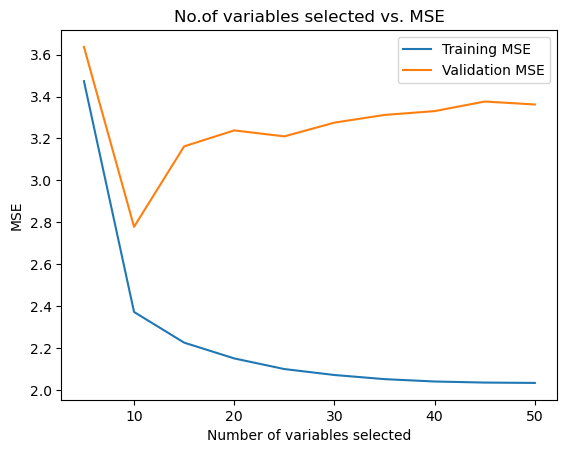

In [11]:
plt.plot(df_avg_train_mse.index,df_avg_train_mse)
plt.plot(df_avg_val_mse.index,df_avg_val_mse)
plt.ylabel('MSE')
plt.xlabel('Number of variables selected')
plt.legend(['Training MSE','Validation MSE'])
plt.title('No.of variables selected vs. MSE')
plt.show()

Selecting 10 variables gives us the lowest validation MSE.

In [12]:
m_ideal = df_avg_val_mse.idxmin() # assigning the optimal variable number to a variable to use further
b = np.zeros(2*m_total+1)
b[0] = m_ideal
sigma = train_x.T @ train_x
obj = -2 * (train_y.T @  train_x)

ojModel = gp.Model() # initialize an empty model
ojModX = ojModel.addMVar(1+2*m_total, lb = lb,vtype = vtype)
ojModCon = ojModel.addMConstrs(A, ojModX, sense, b) # add the constraints to the model
ojModel.setMObjective(sigma,obj,0,sense=gp.GRB.MINIMIZE)
ojModel.Params.OutputFlag = 0 
ojModel.Params.TimeLimit = 3600
ojModel.optimize() # solve the LP

train_sse = (np.square((train_x @ ojModX.X) - train_y)).sum()
train_mse = train_sse/train_y.shape[0]
print('Training MSE: ', train_mse)

test_sse = (np.square((test_x @ ojModX.X) - test_y)).sum()
test_mse = test_sse/test_y.shape[0]
print('Test MSE: ', test_mse)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17
Training MSE:  2.391985266291458
Test MSE:  2.3365439645525248


In [13]:
keys = ['Bias'] + df_train.columns.values.tolist()[1:]
weights = ojModX.X[:m_total+1]
weights_s = pd.Series(weights, index =keys)
weights_s[weights_s!=0] 

Bias    0.972524
X9     -2.308207
X15    -0.518326
X16    -0.204162
X23    -1.559143
X24     0.866973
X26    -1.311919
X34     0.408165
X45     1.781475
X47     0.887383
X48    -0.282292
dtype: float64

The above series of varaibles and beta coefficient values are the final model we obtain after optimizing for the value of m and using that to train the model on the entire training dataset

In [17]:
# this codeblock takes 1 min

from sklearn import model_selection
import warnings
warnings.filterwarnings("ignore")

alphas = 10**np.linspace(1.5,-3,75)

def cv_MSE(X, y, model):
    
    train_SSE_list = []
    val_SSE_list = []
    
    kfold = model_selection.KFold(n_splits=10).split(X = X, y = y)
    for train, holdout in kfold:
        # Select the training and testing data using the indices
        # provided by kfold
        train_X = X[train,:]
        X_holdout = X[holdout,:]
        train_y = y[train]
        y_holdout = y[holdout]
        
        # Fit the model
        model.fit(train_X, train_y)
        train_SSE = mean_squared_error(train_y, model.predict(train_X))* train_y.shape[0]
        train_SSE_list.append(train_SSE)
        # Compute test accuracy
        val_SSE = mean_squared_error(y_holdout, model.predict(X_holdout))* y_holdout.shape[0]
        val_SSE_list.append(val_SSE)
    
    return train_SSE_list,val_SSE_list

train_SSE_dict = {}
val_SSE_dict = {}

for alpha in alphas:
    train_SSE_dict[alpha],val_SSE_dict[alpha] = cv_MSE(train_x[:,:m_total+1], train_y,Lasso(alpha = alpha))


In [18]:
df_lasso_trainSSE = pd.DataFrame(train_SSE_dict)

df_lasso_trainSSE.T.index.name = 'Cross-validation/alpha'
df_lasso_trainSSE.index = df_lasso_trainSSE.index+1
print('Training SSEs: ')
display(df_lasso_trainSSE)

df_lasso_valSSE = pd.DataFrame(val_SSE_dict)

df_lasso_valSSE.T.index.name = 'Cross-validation/alpha'
df_lasso_valSSE.index = df_lasso_valSSE.index+1
print('Validation SSEs: ')
display(df_lasso_valSSE)

Training SSEs: 


Cross-validation/alpha,31.622777,27.490915,23.898926,20.776269,18.061622,15.701674,13.650078,11.866546,10.316052,8.968147,...,0.003526,0.003065,0.002665,0.002317,0.002014,0.001751,0.001522,0.001323,0.001150,0.001000
1,4374.333252,4374.333252,4374.333252,4374.333252,4374.333252,4374.333252,4374.333252,4374.333252,4374.333252,4374.333252,...,470.855783,470.205453,469.816844,469.414376,469.084240,468.756716,468.344108,467.904689,467.622181,467.206053
2,4527.845882,4527.845882,4527.845882,4527.845882,4527.845882,4527.845882,4527.845882,4527.845882,4527.845882,4527.845882,...,462.109918,461.675533,461.182711,460.644954,460.153746,459.649724,459.310854,459.133922,458.963459,458.733033
3,4508.783602,4508.783602,4508.783602,4508.783602,4508.783602,4508.783602,4508.783602,4508.783602,4508.783602,4508.783602,...,461.656282,461.332852,461.031785,460.765368,460.555253,460.392654,460.201362,460.045257,459.946432,459.796040
4,4353.305525,4353.305525,4353.305525,4353.305525,4353.305525,4353.305525,4353.305525,4353.305525,4353.305525,4353.305525,...,465.257992,464.650720,464.203113,463.915692,463.714496,463.576442,463.351543,463.142825,462.918787,462.657324
5,4532.657504,4532.657504,4532.657504,4532.657504,4532.657504,4532.657504,4532.657504,4532.657504,4532.657504,4532.657504,...,484.537595,483.736749,483.137456,482.682061,482.019869,481.694828,481.518599,481.279399,480.787930,480.582444
6,4561.222842,4561.222842,4561.222842,4561.222842,4561.222842,4561.222842,4561.222842,4561.222842,4561.222842,4561.222842,...,471.882469,471.573702,471.301684,471.037494,470.680733,470.260289,469.878113,469.342893,468.851020,468.654010
7,4495.117630,4495.117630,4495.117630,4495.117630,4495.117630,4495.117630,4495.117630,4495.117630,4495.117630,4495.117630,...,464.831983,464.063442,463.536900,463.093263,462.760633,462.474604,462.112568,461.779898,461.478696,461.263468
8,4258.172319,4258.172319,4258.172319,4258.172319,4258.172319,4258.172319,4258.172319,4258.172319,4258.172319,4258.172319,...,435.748874,435.287758,434.939285,434.624435,434.350065,434.110936,433.924692,433.792307,433.692009,433.615993
9,4227.170705,4227.170705,4227.170705,4227.170705,4227.170705,4227.170705,4227.170705,4227.170705,4227.170705,4227.170705,...,444.753601,444.086722,443.405553,442.754397,442.066534,441.351599,440.815729,440.315304,439.760218,439.340540
10,4386.166965,4386.166965,4386.166965,4386.166965,4386.166965,4386.166965,4386.166965,4386.166965,4386.166965,4386.166965,...,454.253433,453.868120,453.520147,453.230480,452.988198,452.804092,452.609005,452.482598,452.390675,452.281366


Validation SSEs: 


Cross-validation/alpha,31.622777,27.490915,23.898926,20.776269,18.061622,15.701674,13.650078,11.866546,10.316052,8.968147,...,0.003526,0.003065,0.002665,0.002317,0.002014,0.001751,0.001522,0.001323,0.001150,0.001000
1,541.529614,541.529614,541.529614,541.529614,541.529614,541.529614,541.529614,541.529614,541.529614,541.529614,...,65.836151,65.663798,65.674749,65.827146,65.985250,66.206891,66.497556,66.761340,66.937176,67.107663
2,388.440980,388.440980,388.440980,388.440980,388.440980,388.440980,388.440980,388.440980,388.440980,388.440980,...,82.647760,82.921120,83.175930,83.437509,83.648935,83.752993,83.876278,84.061205,84.203070,84.326050
3,406.569882,406.569882,406.569882,406.569882,406.569882,406.569882,406.569882,406.569882,406.569882,406.569882,...,83.213803,83.434899,83.497981,83.471999,83.433354,83.397768,83.286510,83.245262,83.205984,83.161198
4,562.236907,562.236907,562.236907,562.236907,562.236907,562.236907,562.236907,562.236907,562.236907,562.236907,...,77.363754,77.587554,77.575117,77.548640,77.603829,77.710888,77.971020,78.045365,77.998040,77.954230
5,385.175455,385.175455,385.175455,385.175455,385.175455,385.175455,385.175455,385.175455,385.175455,385.175455,...,50.989104,51.460765,51.953876,52.402656,52.915532,53.438758,53.957224,54.473444,54.871447,55.037077
6,357.026529,357.026529,357.026529,357.026529,357.026529,357.026529,357.026529,357.026529,357.026529,357.026529,...,69.537784,69.519294,69.303995,69.203026,69.274890,69.230265,69.076891,69.014262,69.037847,68.957810
7,420.320055,420.320055,420.320055,420.320055,420.320055,420.320055,420.320055,420.320055,420.320055,420.320055,...,74.450302,75.382848,76.217579,76.896756,77.066069,77.304755,77.698639,78.090787,78.394786,78.589718
8,657.171650,657.171650,657.171650,657.171650,657.171650,657.171650,657.171650,657.171650,657.171650,657.171650,...,107.731103,108.282172,108.771648,109.296370,109.837119,110.228581,110.579928,110.890060,111.160661,111.398073
9,693.379179,693.379179,693.379179,693.379179,693.379179,693.379179,693.379179,693.379179,693.379179,693.379179,...,107.535187,108.973819,110.606754,112.343480,113.891463,115.292300,116.681375,117.819597,118.609634,119.307277
10,531.405178,531.405178,531.405178,531.405178,531.405178,531.405178,531.405178,531.405178,531.405178,531.405178,...,92.398618,92.384997,92.341895,92.134479,91.926164,91.748297,91.510342,91.367471,91.248531,91.065855


In [19]:
df_avg_lasso_trainMSE = df_lasso_trainSSE.apply(lambda x: x.sum()/(x.count()*(train_y.shape[0]/10)*9))
df_avg_lasso_trainMSE.index.name = 'alpha'
print('Average Training MSE for each value of alpha')
display(df_avg_lasso_trainMSE)

print("\n")

df_avg_lasso_valMSE = df_lasso_valSSE.apply(lambda x: x.sum()/(x.count()*train_y.shape[0]/10))
df_avg_lasso_valMSE.index.name = 'alpha'
print('Average Training MSE for each value of alpha')
display(df_avg_lasso_valMSE)

Average Training MSE for each value of alpha


alpha
31.622777    19.655456
27.490915    19.655456
23.898926    19.655456
20.776269    19.655456
18.061622    19.655456
               ...    
0.001751      2.042254
0.001522      2.040918
0.001323      2.039653
0.001150      2.038405
0.001000      2.037391
Length: 75, dtype: float64



Average Training MSE for each value of alpha


alpha
31.622777    19.773022
27.490915    19.773022
23.898926    19.773022
20.776269    19.773022
18.061622    19.773022
               ...    
0.001751      3.313246
0.001522      3.324543
0.001323      3.335075
0.001150      3.342669
0.001000      3.347620
Length: 75, dtype: float64

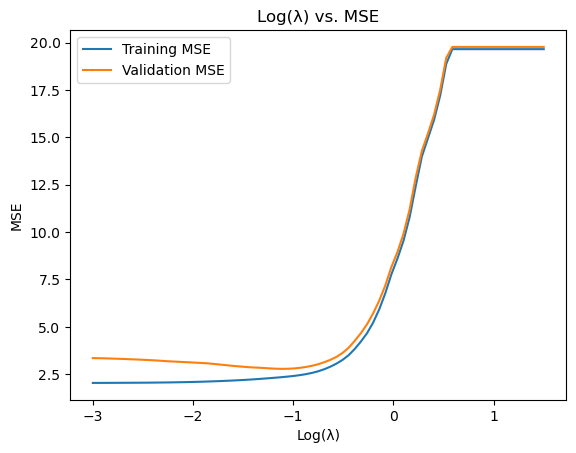

In [20]:
plt.plot(np.log10(df_avg_lasso_trainMSE.index.values),df_avg_lasso_trainMSE)
plt.plot(np.log10(df_avg_lasso_valMSE.index.values),df_avg_lasso_valMSE)
plt.ylabel('MSE')
plt.xlabel('Log(λ)')
plt.legend(['Training MSE','Validation MSE'])
plt.title('Log(λ) vs. MSE')
plt.show()

In [21]:
print('Optimal value of alpha: ',df_avg_lasso_valMSE.idxmin())

Optimal value of alpha:  0.07676002988282571


In [22]:
model = Lasso(alpha = df_avg_lasso_valMSE.idxmin())
model.fit(train_x[:,:m_total+1], train_y)
train_MSE_lasso = mean_squared_error(train_y, model.predict(train_x[:,:m_total+1]))
test_MSE_lasso = mean_squared_error(test_y, model.predict(test_x[:,:m_total+1]))

print('Training MSE: ', train_MSE_lasso)
print('Test MSE: ', test_MSE_lasso)


Training MSE:  2.3697920329900666
Test MSE:  2.3497643393012666


In [23]:
model.coef_[0] = model.intercept_
weights_lasso = reg.coef_
weights_s_lasso = pd.Series(weights_lasso, index =keys)
weights_s_lasso[weights_s_lasso!=0] 

Bias    1.001552
X9     -2.160548
X11    -0.059640
X15    -0.419125
X16    -0.193254
X22    -0.195178
X23    -1.363887
X24     0.742597
X26    -1.304816
X29     0.057983
X33    -0.097378
X34     0.283416
X39    -0.231579
X44     0.030782
X45     1.563622
X46    -0.021600
X47     0.699924
X48    -0.092897
dtype: float64

The above series of varaibles and beta coefficient values are the final model we obtain after optimizing for the value of lambda in Lasso model and using that to train the model on the entire training dataset

In [24]:
df_compare = pd.DataFrame(columns = keys)
df_compare.loc[0] = weights_s
df_compare.loc[1] = weights_s_lasso

df_compare['Training MSE'] = [train_mse,train_MSE_lasso]
df_compare['Test MSE'] = [test_mse,test_MSE_lasso]
df_compare.index = ['MIQP','Lasso']
df_compare

,Bias,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X43,X44,X45,X46,X47,X48,X49,X50,Training MSE,Test MSE
MIQP,0.972524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.308207,...,0.0,0.000000,1.781475,0.0000,0.887383,-0.282292,0.0,0.0,2.391985,2.336544
Lasso,1.001552,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-2.160548,...,0.0,0.030782,1.563622,-0.0216,0.699924,-0.092897,0.0,0.0,2.369792,2.349764


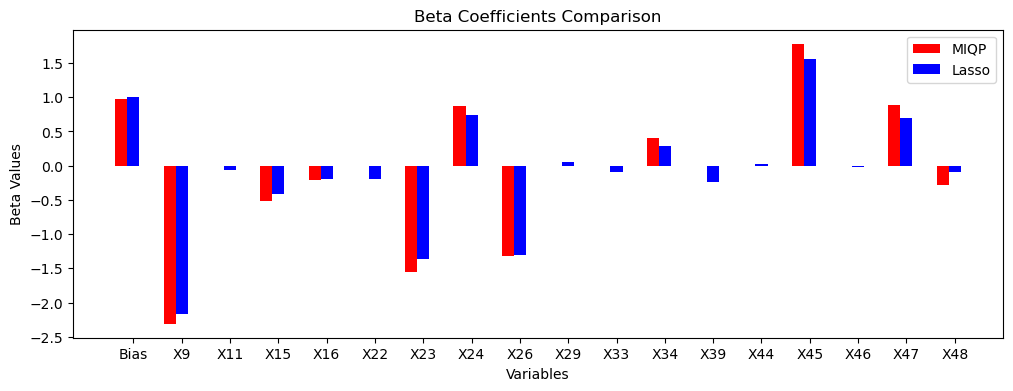

In [66]:
m = (df_compare != 0).any()
a = m.index[m]
df_compare[a[:-2]]

fig = plt.subplots(figsize =(12, 4))
barWidth = 0.25

br1 = np.arange(a[:-2].shape[0])
br2 = [x + barWidth for x in br1]

plt.bar(br1,df_compare.loc['MIQP'][a[:-2]], color = 'r', width = barWidth, label = 'MIQP')
plt.bar(br2,df_compare.loc['Lasso'][a[:-2]], color = 'b', width = barWidth, label = 'Lasso')

# plt.bar(br1, IT, color ='r', width = barWidth, edgecolor ='grey', label ='IT')
# plt.bar(br2, ECE, color ='g', width = barWidth, edgecolor ='grey', label ='ECE')

plt.xlabel("Variables")
plt.ylabel("Beta Values")
plt.xticks([r + barWidth for r in range(a[:-2].shape[0])],a[:-2].to_list())
plt.legend()
plt.title("Beta Coefficients Comparison")
plt.show()

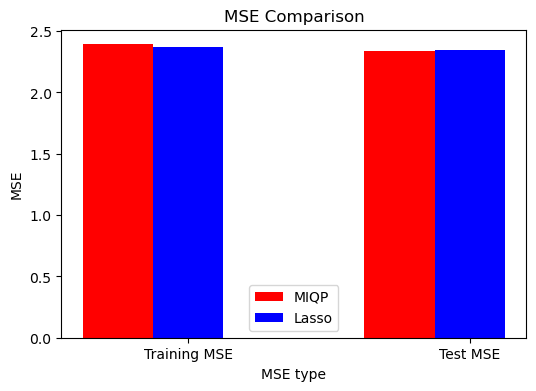

In [73]:
fig = plt.subplots(figsize =(6, 4))
barWidth = 0.25

br1 = np.arange(a[-2:].shape[0])
br2 = [x + barWidth for x in br1]

plt.bar(br1,df_compare.loc['MIQP'][a[-2:]], color = 'r', width = barWidth, label = 'MIQP')
plt.bar(br2,df_compare.loc['Lasso'][a[-2:]], color = 'b', width = barWidth, label = 'Lasso')


plt.xlabel("MSE type")
plt.ylabel("MSE")
plt.xticks([r + barWidth for r in range(a[-2:].shape[0])],a[-2:].to_list())
plt.legend()
plt.title("MSE Comparison")
plt.show()